In [78]:
%load_ext autoreload
%autoreload 2

from exchange_data.data.macd_frame import MacdFrame
import pandas as pd
import numpy as np
import alog
import plotly.graph_objs as go
import plotly.express as px
import plotly as py
import plotly.offline as ofl
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)
params = {
 'database_name': 'binance_futures',
 'futures': False,
 'group_by': '1m',
 'interval': '7d',
 'offset_interval': '0h',
 'symbol': 'UNFIUSDT'
}

df = MacdFrame(**params).frame

#pd.set_option("display.max_rows", len(df) + 1)

df


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2023-11-18 13:15:38 INFO  [data.macd_frame:47] SELECT last(best_bid) AS data FROM UNFIUSDT_OrderBookFrame WHERE time >= '2023-11-11 19:15:38.942856' AND time <= '2023-11-18 19:15:38.942872' GROUP BY time(1m)
2023-11-18 13:15:38 DEBUG [exchange_data._database:64] SELECT last(best_bid) AS data FROM UNFIUSDT_OrderBookFrame WHERE time >= '2023-11-11 19:15:38.942856' AND time <= '2023-11-18 19:15:38.942872' GROUP BY time(1m)
2023-11-18 13:15:39 INFO  [data.macd_frame:62]                            price
time                            
2023-11-11 19:15:00+00:00  9.328
2023-11-11 19:16:00+00:00  9.330
2023-11-11 19:17:00+00:00  9.324
2023-11-11 19:18:00+00:00  9.326
2023-11-11 19:19:00+00:00  9.323
...                          ...
2023-11-18 19:11:00+00:00  8.735
2023-11-18 19:12:00+00:00  8.724
2023-11-18 19:13:00+00:00  8.706
2023-11-18 19:14:00+00:00  8.711
2023-11-18 19:15:00+00:00  8.717

[10081 rows x 1 columns]


,open,high,low,close,macd_diff,trade
time,,,,,,
2023-11-11 19:10:00+00:00,9.328,9.330,9.323,9.323,0.000000,0
2023-11-11 19:20:00+00:00,9.332,9.340,9.324,9.340,0.000000,0
2023-11-11 19:30:00+00:00,9.342,9.374,9.342,9.374,0.000000,0
2023-11-11 19:40:00+00:00,9.370,9.392,9.369,9.392,0.000000,0
2023-11-11 19:50:00+00:00,9.386,9.386,9.364,9.386,0.000000,0
...,...,...,...,...,...,...
2023-11-18 18:30:00+00:00,8.720,8.720,8.686,8.714,-0.007511,1
2023-11-18 18:40:00+00:00,8.723,8.733,8.715,8.728,-0.005512,1
2023-11-18 18:50:00+00:00,8.717,8.741,8.717,8.741,-0.003220,1


In [103]:
from scipy.signal import argrelextrema
n = 7

min = argrelextrema(df['open'].to_numpy(), np.less_equal, order=n)[0]
max = argrelextrema(df['open'].to_numpy(), np.greater_equal, order=n)[0]
position = []
active_trade = False

for ix in range(0, df.shape[0]):
    if ix in max:
        active_trade=True
    if ix in min:
        active_trade=False
        
    if active_trade:
        position.append(1)
    else:
        position.append(0)

df['trade'] = position
df

,open,high,low,close,macd_diff,trade,capital
time,,,,,,,
2023-11-11 19:10:00+00:00,9.328,9.330,9.323,9.323,0.000000,0,1.00000
2023-11-11 19:20:00+00:00,9.332,9.340,9.324,9.340,0.000000,0,1.00000
2023-11-11 19:30:00+00:00,9.342,9.374,9.342,9.374,0.000000,0,1.00000
2023-11-11 19:40:00+00:00,9.370,9.392,9.369,9.392,0.000000,0,1.00000
2023-11-11 19:50:00+00:00,9.386,9.386,9.364,9.386,0.000000,1,1.00000
...,...,...,...,...,...,...,...
2023-11-18 18:30:00+00:00,8.720,8.720,8.686,8.714,-0.007511,0,2.55669
2023-11-18 18:40:00+00:00,8.723,8.733,8.715,8.728,-0.005512,0,2.55669
2023-11-18 18:50:00+00:00,8.717,8.741,8.717,8.741,-0.003220,0,2.55669


In [104]:
capital = 1
df['capital'] = 0
df_len = df.shape[0]
capital_ls = []
price_in = None

for ix in range(0, df_len):
    if ix < df_len - 1:
        row = df.iloc[ix]
        next_row = df.iloc[ix + 1]
        best_ask = row['open']
        
        if row['trade'] == 1:
            if price_in == None:
                price_in = best_ask
        else:
            if price_in:
                pnl = (price_in - best_ask) / price_in
                capital = capital + (capital * pnl)
                
            price_in = None
            
    #alog.info(capital)
    capital_ls.append(capital)

df['capital'] = np.asarray(capital_ls)

df

,open,high,low,close,macd_diff,trade,capital
time,,,,,,,
2023-11-11 19:10:00+00:00,9.328,9.330,9.323,9.323,0.000000,0,1.000000
2023-11-11 19:20:00+00:00,9.332,9.340,9.324,9.340,0.000000,0,1.000000
2023-11-11 19:30:00+00:00,9.342,9.374,9.342,9.374,0.000000,0,1.000000
2023-11-11 19:40:00+00:00,9.370,9.392,9.369,9.392,0.000000,0,1.000000
2023-11-11 19:50:00+00:00,9.386,9.386,9.364,9.386,0.000000,1,1.000000
...,...,...,...,...,...,...,...
2023-11-18 18:30:00+00:00,8.720,8.720,8.686,8.714,-0.007511,0,2.738758
2023-11-18 18:40:00+00:00,8.723,8.733,8.715,8.728,-0.005512,0,2.738758
2023-11-18 18:50:00+00:00,8.717,8.741,8.717,8.741,-0.003220,0,2.738758


In [105]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

/home/joliveros/.pyenv/versions/3.8.10/envs/exchange-data/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




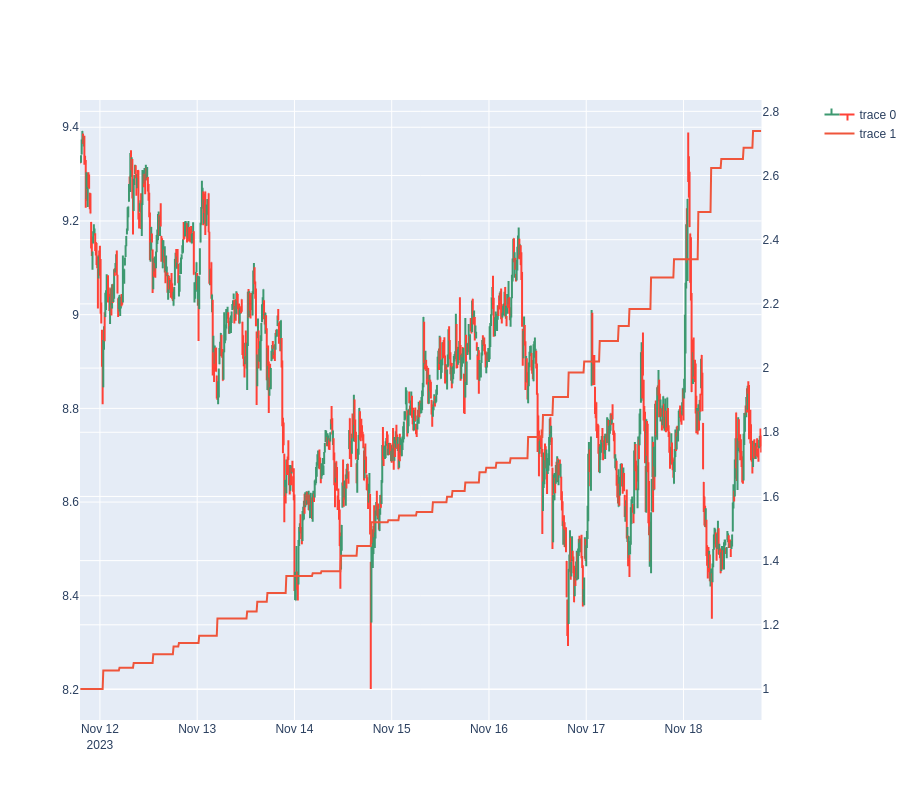

In [106]:
fig1 = go.Ohlc(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])

fig2 = go.Line(
    x=df.index,
    y=df['capital'],
    yaxis='y2'
)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(fig1)
fig.add_trace(fig2,secondary_y=True)
fig.update_layout(height=800)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()